<img src="img/logo.png" align="left"/>

# Assessment of Noise Levels in the Intensive Care Unit Using Apple Watch

## STEP 1: Export Data from Apple Health App on your iPhone

* Export your data from the Health app on your iPhone
* Unzip export.zip into this folder and rename the unzipped folder to data
* Inside the folder /data there should be a file called export.xml

## STEP 2: Extract Environmental Audio Exposure data

* Command Line Tool to process data exported from Health app contained in the export.xml file (Credits: https://github.com/tdda/applehealthdata)
* This script create multiple .csv files for each data type
* To analyse noise leves we need only EnvironmentalAudioExposure.csv file as it contains recordings of noise levels
* Based on the size of your Health daata, this script may take several minutes to complete

In [ ]:
%run -i 'apple-health-data-parser' 'data/export.xml' 

## STEP 3: Manually select samples recorded in the ICU

* Open EnvironmentalAudioExposure.csv file with Excel containing all data about noise levels recorded by Apple Watch
* Remove rows of samples recorded outside ICU
* Save file as noise_samples_icu.csv inside /data folder

## STEP 3: Data Analysis

In [29]:
#Import necessary Libraries to perform data analysis
from datetime import date, datetime, timedelta as td
import pytz
import numpy as np
import scipy.stats as stats
import pandas as pd
import glob
import matplotlib, matplotlib.pyplot as plt
%matplotlib inline

In [30]:
# Functions to convert UTC to your time zone and extract date and time
convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Europe/Rome'))
extract_year = lambda x: convert_tz(x).year
extract_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month)
extract_date = lambda x: '{}-{:02}-{:02}'.format(convert_tz(x).year, convert_tz(x).month, convert_tz(x).day)
extract_day = lambda x: convert_tz(x).day
extract_hour = lambda x: convert_tz(x).hour
extract_time = lambda x: convert_tz(x).time()
extract_minute = lambda x: convert_tz(x).minute
extract_day_of_week = lambda x: convert_tz(x).weekday()

In [31]:
#Read file noise_samples_icu.csv containing all data about noise levels recorded by Apple Watch in ICU
df_noise = pd.read_csv("data/noise_samples_icu.csv")

In [32]:
#Coversion of date and time field
df_noise['startDate'] = pd.to_datetime(df_noise['startDate'])
df_noise['endDate'] = pd.to_datetime(df_noise['endDate'])

#Extract of date from datetime field
df_noise['date'] = df_noise['startDate'].map(extract_date)

#Extract hour from datetime field: 2019-11-09 06:40:12+01:00 ==> 6
df_noise['hour'] = df_noise['startDate'].map(extract_hour)

#Extract Day Of Week (DOW)
#0 = Monday, ..., 6 = Sunday
df_noise['dow'] = df_noise['startDate'].map(extract_day_of_week)

In [33]:
#Use only needed columns
df_noise = df_noise[['startDate','endDate', 'value', 'date', 'hour', 'dow']]

#Display top 10 rows
df_noise.head(10)

,startDate,endDate,value,date,hour,dow
0,2019-11-09 06:10:17+01:00,2019-11-09 06:40:12+01:00,61.1100,2019-11-09,7,5
1,2019-11-09 06:40:12+01:00,2019-11-09 07:10:12+01:00,68.2660,2019-11-09,7,5
2,2019-11-09 07:10:12+01:00,2019-11-09 07:40:12+01:00,75.0590,2019-11-09,8,5
3,2019-11-09 07:40:12+01:00,2019-11-09 08:10:07+01:00,63.1557,2019-11-09,8,5
4,2019-11-09 08:10:07+01:00,2019-11-09 08:40:07+01:00,63.3232,2019-11-09,9,5
5,2019-11-09 08:40:07+01:00,2019-11-09 09:10:07+01:00,68.7593,2019-11-09,9,5
6,2019-11-09 09:10:07+01:00,2019-11-09 09:40:02+01:00,68.1763,2019-11-09,10,5
7,2019-11-09 09:40:02+01:00,2019-11-09 10:09:57+01:00,63.7485,2019-11-09,10,5
8,2019-11-09 10:09:57+01:00,2019-11-09 10:39:57+01:00,68.8601,2019-11-09,11,5
9,2019-11-09 10:39:57+01:00,2019-11-09 11:09:57+01:00,66.7737,2019-11-09,11,5


### Analysis 1: Noise levels in ICU during daytime vs night-time

In [34]:
# 1. Define daytime and night-time hours
h_start_day = 7 #included
h_end_day = 22 #included

# 2. Compute a column that identifies samples as daytime (= 1) and night-time (= 0)
df_noise.loc[(df_noise['hour'] >= h_start_day) & (df_noise['hour'] <= h_end_day), 'daytime'] = 1 
df_noise.loc[df_noise['daytime'] != 1, 'daytime'] = 0

# 3. Display top 10 rows
df_noise.head(10)

# 4. Group by daytime (= 1) and night-time (= 0)
groupby_hours = df_noise.groupby('daytime')

In [35]:
# 4. Display count, mean, std, min, 25%, 50%, 75% and max
groupby_hours["value"].describe()

,count,mean,std,min,25%,50%,75%,max
daytime,,,,,,,,
0.0,367.0,64.112867,4.177578,48.9973,61.71830,64.1704,67.0787,76.5906
1.0,719.0,66.569402,6.735177,31.0714,65.27455,67.1327,69.2362,88.6490


In [36]:
# 5. Compute t-test between the two groups: daytime (= 1) and night-time (= 0)

# Create two dataframes with noise levels from the two groups
df_values_daytime = df_noise[df_noise["daytime"]==1]["value"]
df_values_nighttime = df_noise[df_noise["daytime"]==0]["value"]

# 5. Compute and display t-test
t2, p2 = stats.ttest_ind(a=df_values_daytime,b=df_values_nighttime ,equal_var = False)
print("t = " + str(t2))
print("p = " + str(p2))

t = 7.385116247757598
p = 3.108910072761726e-13


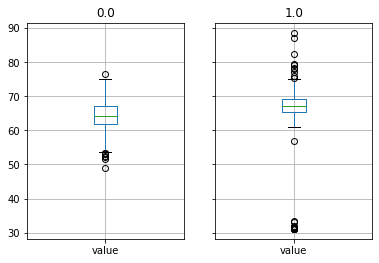

In [37]:
# 6. Display BoxPlot and save the image

# Create BoxPlot
boxplot = groupby_hours.boxplot(column=['value'], return_type='axes')

# Save figure as PDF
plt.savefig('figures/boxplot_daytime_vs_nighttime.pdf')

### Analysis 2: Noise levels in ICU by day of week

In [38]:
# 1. Group by day of week (dow) and calculate mean and std for each dow
# 0 = Monday, ..., 6 = Sunday
df_avg_noise_dow = df_noise.groupby('dow').agg({'value': ['mean', 'std']})

# 2. Display top 10 rows
df_avg_noise_dow.head(10)

value           
          mean        std
dow                      
0    64.669809   5.059864
1    67.181821   3.029694
2    67.141110   3.380042
3    65.773104   4.164719
4    67.486586   3.728125
5    66.095206   3.844973
6    61.809254  11.662093

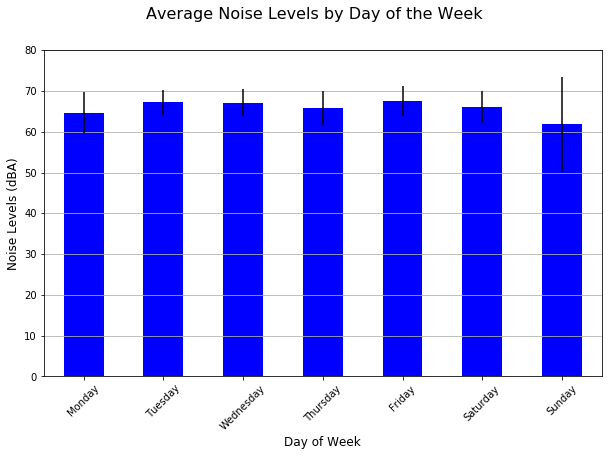

In [39]:
# 3. Display Bar Plot with std
fig, ax = plt.subplots(figsize=[10, 6])

ax = df_avg_noise_dow["value"]["mean"].plot(kind='bar', x='day_of_week', color='blue', yerr=df_avg_noise_dow["value"]["std"])
ax.set_ylim((0, 80))

n_groups = len(df_avg_noise_dow)
index = np.arange(n_groups)
opacity = 0.75

ax.yaxis.grid(True)

plt.suptitle('Average Noise Levels by Day of the Week', fontsize=16)
dow_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(index, dow_labels, rotation=45)
plt.xlabel('Day of Week', fontsize=12, color='black')
plt.ylabel('Noise Levels (dBA)', fontsize=12, color='black')

# 4. Save figure as PDF
plt.savefig('figures/barplot_avg_noise_by_dow.pdf')

### Analysis 3: Noise levels in ICU by hour of the day

In [40]:
# 1. Group by hour of the day and calculate mean and std for each hour
df_noise_by_hour = df_noise.groupby('hour').agg({'value': ['mean', 'std']})

# 2. Display all rows with mean and std
df_noise_by_hour

value          
           mean       std
hour                     
0     65.972021  3.218239
1     64.751429  3.764711
2     64.243696  3.412625
3     63.246933  3.821426
4     61.162225  4.362913
5     62.326521  4.349785
6     64.177603  3.900302
7     66.269507  2.430642
8     67.619404  2.937055
9     67.093187  6.244321
10    67.234424  8.980887
11    66.530700  7.963518
12    66.590239  8.700681
13    67.465511  8.142208
14    66.272278  8.188320
15    65.478352  7.877435
16    66.487196  8.177797
17    65.281702  7.613496
18    65.547991  7.703148
19    66.942896  6.169718
20    67.010054  3.159570
21    65.892592  2.871828
22    67.438035  2.870342
23    67.535068  3.083778

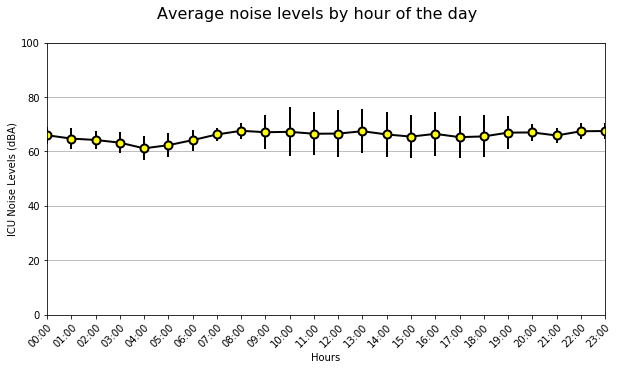

In [41]:
# 3. Display Line Plot with std
fig, ax = plt.subplots(figsize=[10, 6])
ax = df_noise_by_hour["value"]["mean"].plot(kind='line', figsize=(10, 5), yerr=df_noise_by_hour["value"]["std"], legend=False, linewidth=2, alpha=1, marker='o', color='black', markeredgecolor='black', markerfacecolor='yellow', markersize=8, markeredgewidth=2)

xlabels = df_noise_by_hour.index.map(lambda x: '{:02}:00'.format(x))
ax.set_xticks(range(len(xlabels)))
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right')

ax.set_xlim((df_noise_by_hour.index[0], df_noise_by_hour.index[-1]))
ax.set_ylim((0, 100))

ax.yaxis.grid(True)
ax.set_ylabel('ICU Noise Levels (dBA)')
ax.set_xlabel('Hours')
plt.suptitle('Average noise levels by hour of the day', fontsize=16)

# 4. Save figure as PDF
plt.savefig('figures/lineplot_noise_by_hour.pdf')

### Analysis 4: Noise levels in ICU within WHO recommended range

In [42]:
# 1. Filters
dayhours_filter = df_noise["daytime"] == 1
nighthours_filter = df_noise["daytime"] == 0
WHO_day_35dBA_limit = df_noise["value"] <= 35
WHO_night_30dBA_limit = df_noise["value"] <= 30

# 2. Count totale samples and samples within range during daytime and nighttime
values_during_dayhours = df_noise["value"][dayhours_filter].count()
values_below_35dba_during_dayhours = df_noise["value"][WHO_day_35dBA_limit].count()

values_during_nighthours = df_noise["value"][nighthours_filter].count()
values_below_30dba_during_nighthours = df_noise["value"][WHO_night_30dBA_limit].count()

In [43]:
# 3. Display results
print("% of values within WHO 35 dBA limit during daytime:")
print((values_below_35dba_during_dayhours/values_during_dayhours)*100)

% of values within WHO 35 dBA limit during daytime:
2.781641168289291


In [44]:
print("% of values within WHO 30 dBA limit during night:")
print((values_below_30dba_during_nighthours/values_during_nighthours)*100)

% of values within WHO 30 dBA limit during night:
0.0


### Other analysis

In [45]:
# 1. Lowest noise level
df_noise.sort_values(by=['value'], ascending = True).head(1)

,startDate,endDate,value,date,hour,dow,daytime
424,2019-12-22 14:16:24+01:00,2019-12-22 14:46:24+01:00,31.0714,2019-12-22,15,6,1.0


In [46]:
# 2. Highest noise level
df_noise.sort_values(by=['value'], ascending = False).head(1)

,startDate,endDate,value,date,hour,dow,daytime
528,2020-01-06 11:07:43+01:00,2020-01-06 11:37:38+01:00,88.649,2020-01-06,12,0,1.0
